In [ ]:
import random
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import torch
import torchvision
from torch import nn
import albumentations as A
from torchvision import models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

**Dataset Downloader**

In [ ]:
dataset = torchvision.datasets.CIFAR10('/content/', train=True, download=True)
dataset

100%|██████████| 170498071/170498071 [00:03<00:00, 50802201.19it/s]


Extracting /content/cifar-10-python.tar.gz to /content/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/
    Split: Train

**Augmentation**

In [ ]:
alb_transforms = A.Compose(
    [
        A.HorizontalFlip(),
        A.Rotate(limit=40, p=0.7),
        A.IAAPerspective(scale=(0.1, 0.1), p=0.7),
        A.IAASuperpixels(p_replace=0.3, p=0.7),
        A.IAAAdditiveGaussianNoise(scale=(0.1 * 255, 0.2 * 255), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.7),
    ]
)

**DatasetLoader**

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, dataset, split, train = True, alb_transforms=None):
      if train:
        data = dataset.data[:split_length]
        self.label = dataset.targets[:split_length]
      else:
        data = dataset.data[split_length:]
        self.label = dataset.targets[split_length:]
      
      self.transform = False
      
      if alb_transforms is not None:
        self.transform = True
        data_alb = []
        data_image = []
        for image in tqdm(data):
          # transforming and normalizing image
          image_alb = alb_transforms(image=image)["image"]
          image = image.astype(np.float16)
          image_alb = image_alb.astype(np.float16)

          image = torch.from_numpy(image)
          image = image.float()
          image_alb = torch.from_numpy(image_alb)
          image_alb = image_alb.float()
          # image channel correction
          if len(image.shape) < 3:
              image = image.unsqueeze(0)
              image_alb = image_alb.unsqueeze(0)
          else:
            image = image.movedim(2,0)
            image_alb = image_alb.movedim(2,0)
          data_image.append(image)
          data_alb.append(image_alb)
        
        self.data_alb = torch.stack(data_alb)
        self.data = torch.stack(data_image)
      
      else:
        data_image = []
        for image in tqdm(data):
          # normalizing image
          image = image.astype(np.float16)
          image = torch.from_numpy(image)
          image = image.float()
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
          else:
            image = image.movedim(2,0)
          data_image.append(image)
        self.data = torch.stack(data_image)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = torch.from_numpy(np.array(self.label[idx], dtype = np.float16))

        if self.transform:
          image_alb = self.data_alb[idx]
          return (image, image_alb, label)
        else:
          return (image, label)

In [ ]:
split_length = int(0.95*len(dataset))
print("Train dataset: ", split_length)
print("Test dataset: ", len(dataset)-split_length)
# training data
print("Training Dataset --->")
trainDatasetLoader = DatasetLoader(dataset, split_length, train = True,
                                   alb_transforms=alb_transforms)
dataloader_train = DataLoader(trainDatasetLoader, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)
# validation data
print("Validation Dataset --->")
valDatasetLoader = DatasetLoader(dataset, split_length, train = False,
                                   alb_transforms=alb_transforms)
dataloader_val = DataLoader(valDatasetLoader, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)

Train dataset:  47500
Test dataset:  2500
Training Dataset --->


  0%|          | 0/47500 [00:00<?, ?it/s]

Validation Dataset --->


  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
val = next(iter(dataloader_train))
print(val[0].shape)
print(val[1].shape)
print(val[2].shape)
del val

torch.Size([1024, 3, 32, 32])
torch.Size([1024, 3, 32, 32])
torch.Size([1024])


# Model Architectures

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(ResidualBlock, 16, 3, stride = 1)
        self.layer1 = self._make_layer(ResidualBlock, 32, 4, stride = 2)
        self.layer2 = self._make_layer(ResidualBlock, 64, 6, stride = 2)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [ ]:
#new
class ResNetClusterisator(nn.Module):
    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        final_features = 1024
        self.resnet = ResNet()
        self.flatten = nn.Flatten()
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head_1 = nn.Linear(final_features, 20)
        self.overcluster_head_2 = nn.Linear(final_features, 30)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, overclustering=False, head_num=1):
        x = self.resnet(x)
        x = self.flatten(x)
        
        if overclustering:
            if head_num == 1:
                x = self.overcluster_head_1(x)
            elif head_num == 2:
                x = self.overcluster_head_2(x)
        else:
            x = self.cluster_head(x)
        
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda
The model is transfered to cuda
The weights are Initialised.


In [ ]:
val = next(iter(dataloader_train))
input_batch = val[0]
input_batch = input_batch.to(device)
print("Model output shape in clustering mode:", model(input_batch).shape)
print("Model output shape in overclustering mode 1:", model(input_batch, overclustering=True, head_num=1).shape)
print("Model output shape in overclustering mode 2:", model(input_batch, overclustering=True, head_num=2).shape)

Model output shape in clustering mode: torch.Size([1024, 10])
Model output shape in overclustering mode 1: torch.Size([1024, 20])
Model output shape in overclustering mode 2: torch.Size([1024, 30])


**Loss**

In [ ]:
#new
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()
    # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
    # shape: [10,10]
    p_i_j = p_i_j.sum(dim=0)
    p_i_j = (p_i_j + p_i_j.t()) / p_i_j.sum()  # Normalization
    
    # To avoid NaN losses for small p_i_j
    p_i_j[(p_i_j < EPS).data] = EPS

    # Computing the marginals
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes)
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes)

    # Compute the mutual information
    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
    loss = torch.sum(loss)
    return loss

In [ ]:
# loss testing
input_batch = val[0]
input_batch = input_batch.to(device)
aug_image_batch = val[1]
aug_image_batch = aug_image_batch.to(device)

lamb = 1.0
outputs = model(input_batch)
outputs_tf = model(aug_image_batch, overclustering = False)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print("Loss:", loss.data.cpu().numpy())

Loss: 1.3842213


In [ ]:
del val

**Evaluation Function**

In [ ]:
def evaluate(model, dataloader, overclustering=False, lamb=1.0, 
             device=torch.device("cpu")):
    losses = []
    if overclustering:
      print("Overhead Clustering Evaluation --->")
    else:
      print("Clustering Evaluation --->")
    model.eval()
    for batch in tqdm(dataloader):
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
        loss = IID_loss(outputs, outputs_tf, lamb=lamb)
        losses.append(loss.data.cpu().numpy())
    return np.mean(losses)

**Auxilary Function**

In [ ]:
def model_test(model, dataloader,device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch[0].to(device)
        labels = batch[2].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels

def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(10)])
        ax.bar(list(range(10)), counts)
        ax.set_xticks(np.arange(10))
        ax.set_xlim([0, 9])
        ax.set_title("Original label: %i" % idx)

In [ ]:
def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(10)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

**Training Code**

In [ ]:
def one_hot(x, classes=10):
  one_hot = []
  for i in x:
    temp = [0]*classes
    temp[int(i.item())] = 1
    one_hot.append(temp)
  one_hot = torch.Tensor(one_hot)
  return one_hot.float()

def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5):
    
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    best_cluster_loss = 0
    best_overcluster_loss = 0

    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs_1 = model(inputs, False)
            outputs_tf_1 = model(inputs_tf, False)
            loss1 = IID_loss(outputs_1, outputs_tf_1, lamb=1.0)
            outputs_2 = model(inputs, True)
            outputs_tf_2 = model(inputs_tf, True)
            loss2 = IID_loss(outputs_2, outputs_tf_2, lamb=1.0)
            outputs_3 = model(inputs, True, head_num=2)
            outputs_tf_3 = model(inputs_tf, True, head_num=2)
            loss3 = IID_loss(outputs_3, outputs_tf_3, lamb=1.0)
            targets = one_hot(batch[2])
            targets = targets.to(device=device)
            loss4 = loss_fn(outputs_1, targets)
            loss1 = loss1*0.2
            loss2 = loss2*0.2
            loss3 = loss3*0.2
            loss4 = loss4*0.4
            loss = loss1+loss2+loss3+loss4
            loss.backward()
            optimizer.step()
        # evaluation
        if (epoch + 1) % eval_every == 0:
            loss_eval = evaluate(
                model, dataloader_val, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader_val, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            # print(loss_history)
            loss_history_overclustering.append(loss_eval_overclustering)
            # print(loss_history_overclustering)
            epochs_list.append(epoch)
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "/content/best_loss_model_cifar10.pth")
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
    # print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

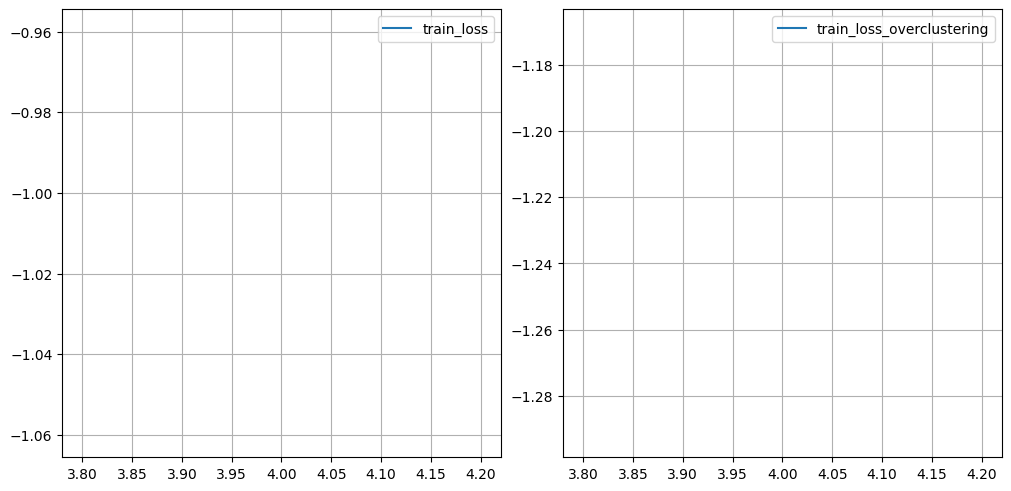

Epoch 6/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

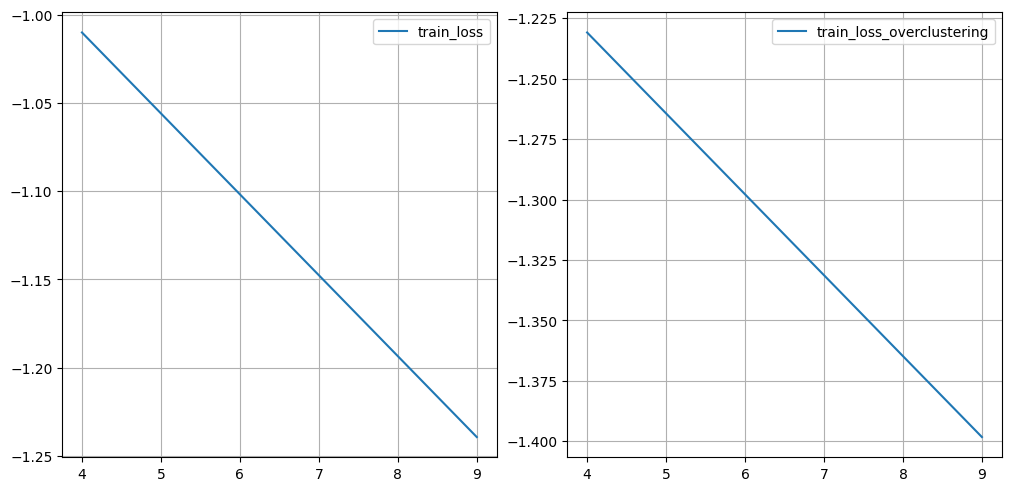

Epoch 11/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

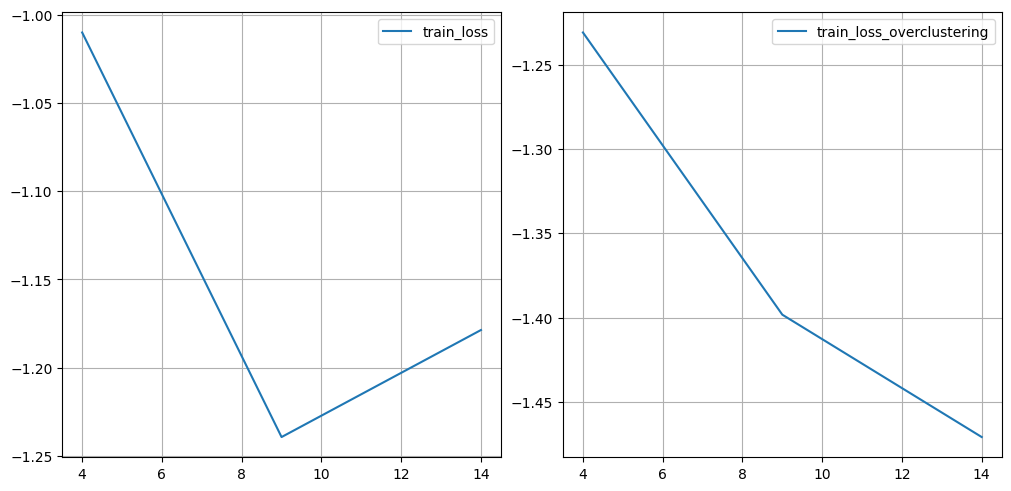

Epoch 16/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

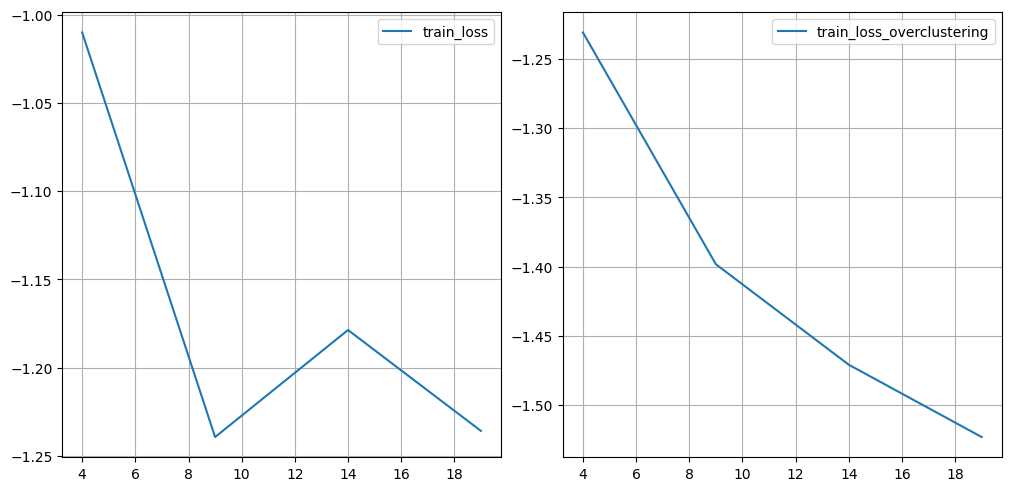

Epoch 21/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

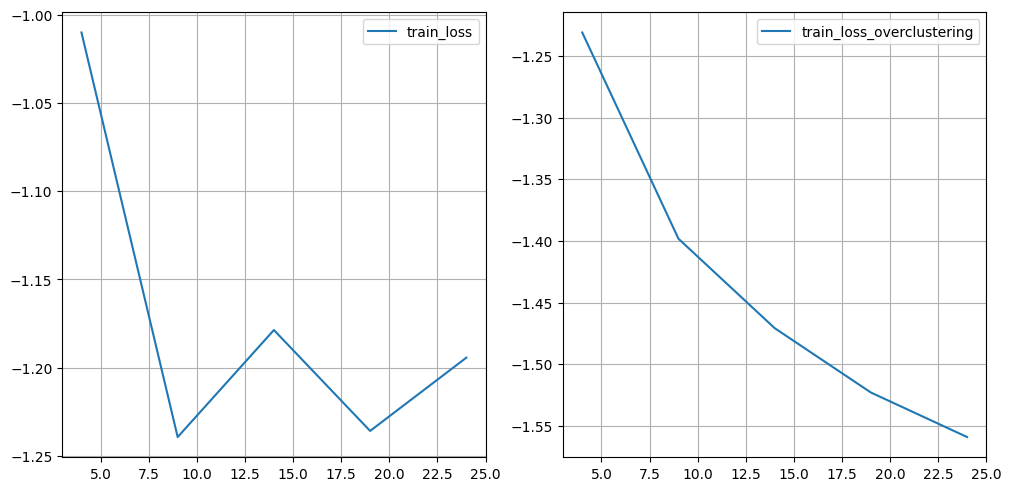

Epoch 26/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

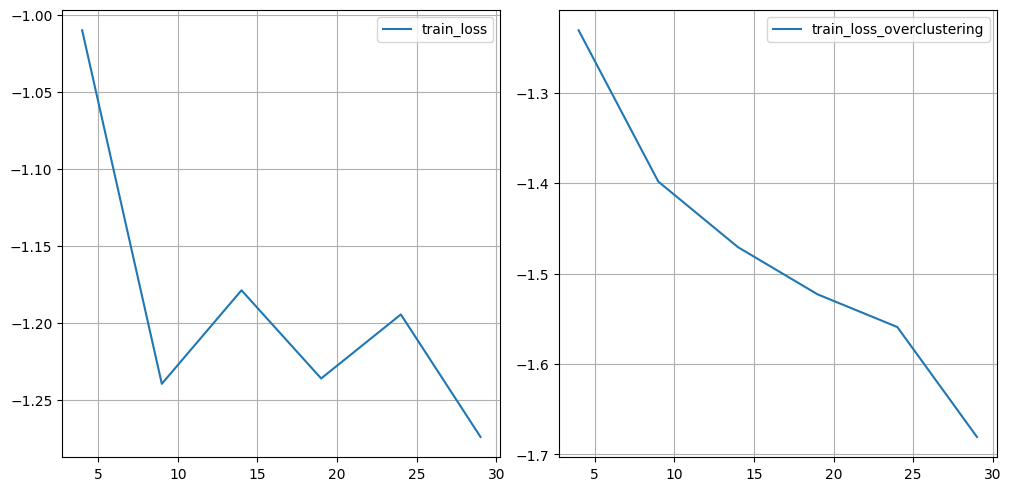

Epoch 31/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 33/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

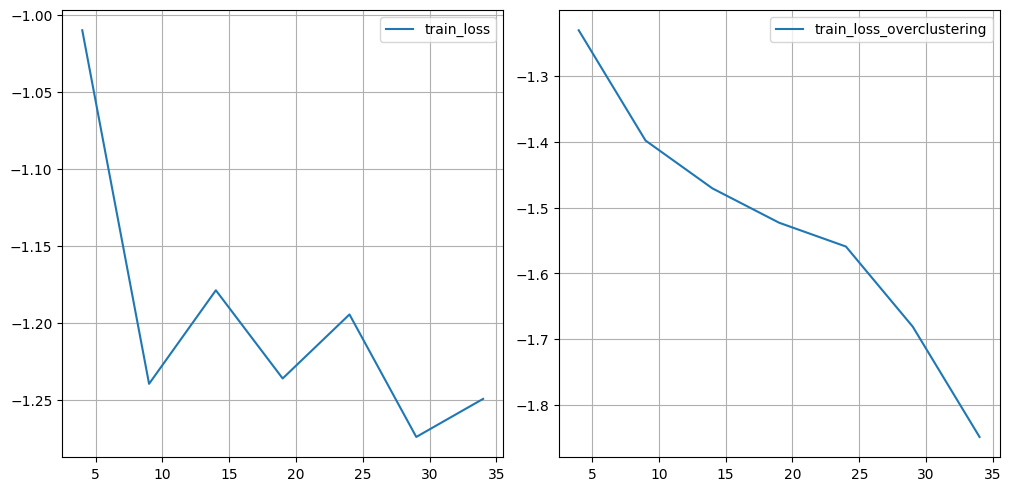

Epoch 36/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 38/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 40/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

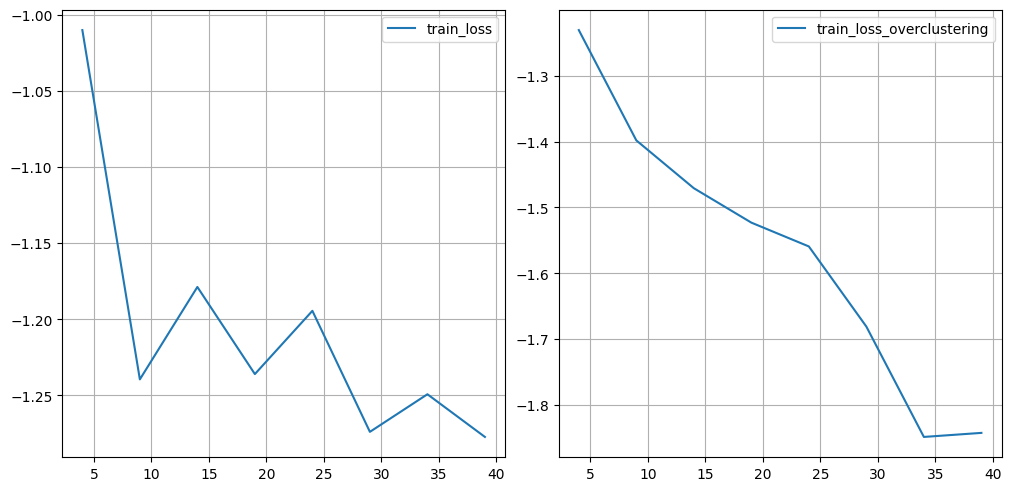

Epoch 41/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 42/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 44/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

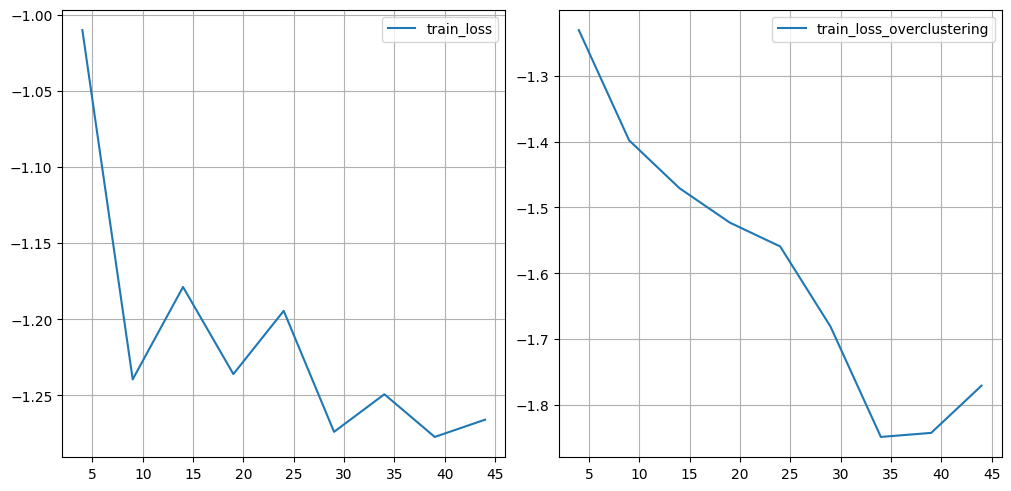

Epoch 46/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 48/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 50/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

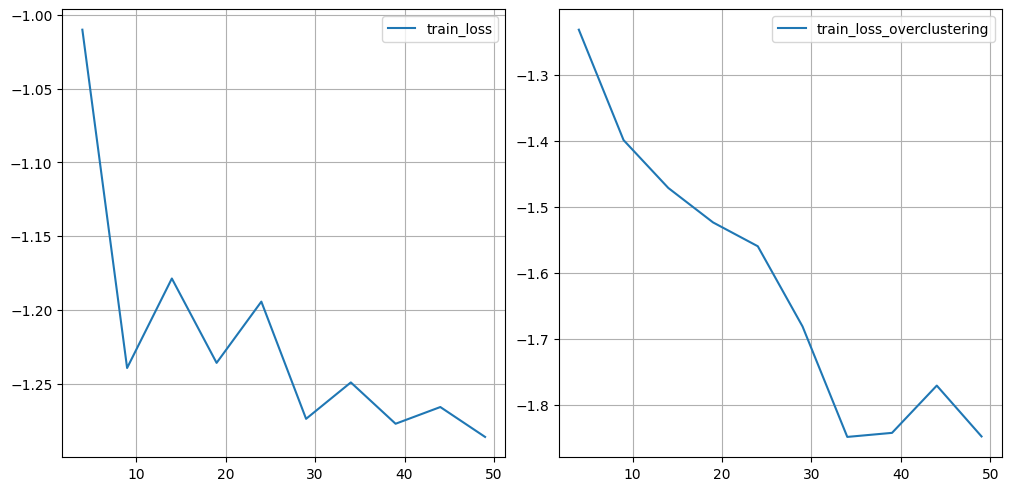

Epoch 51/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 52/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 53/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 54/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 55/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

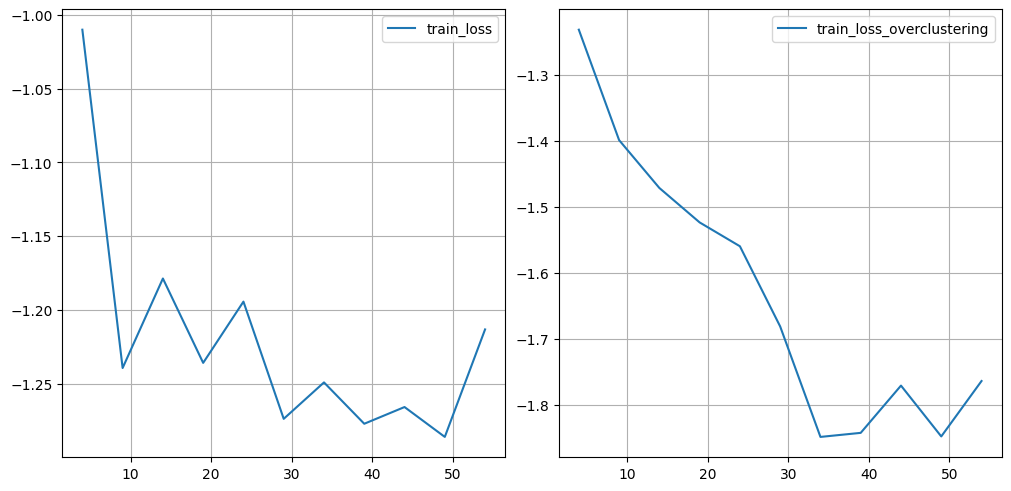

Epoch 56/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 57/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 58/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 59/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 60/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

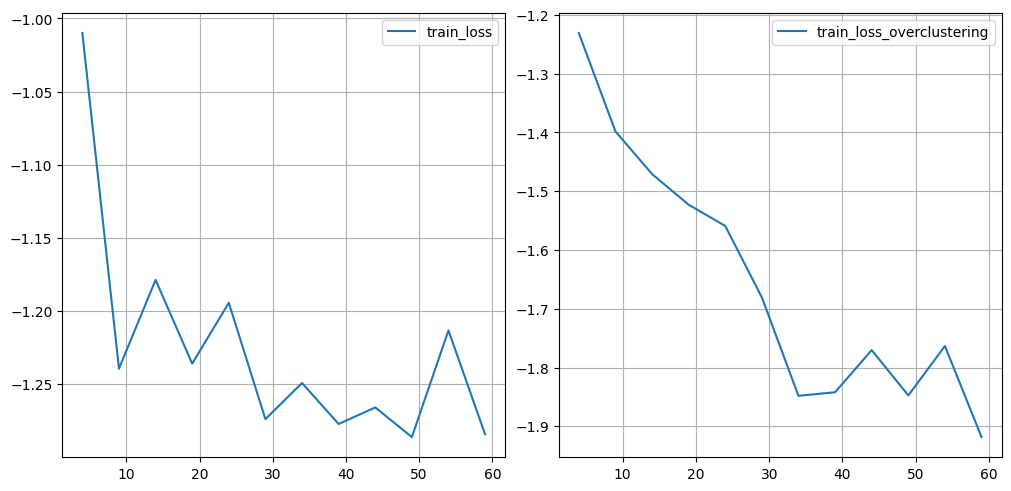

Epoch 61/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 62/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 63/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 64/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 65/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

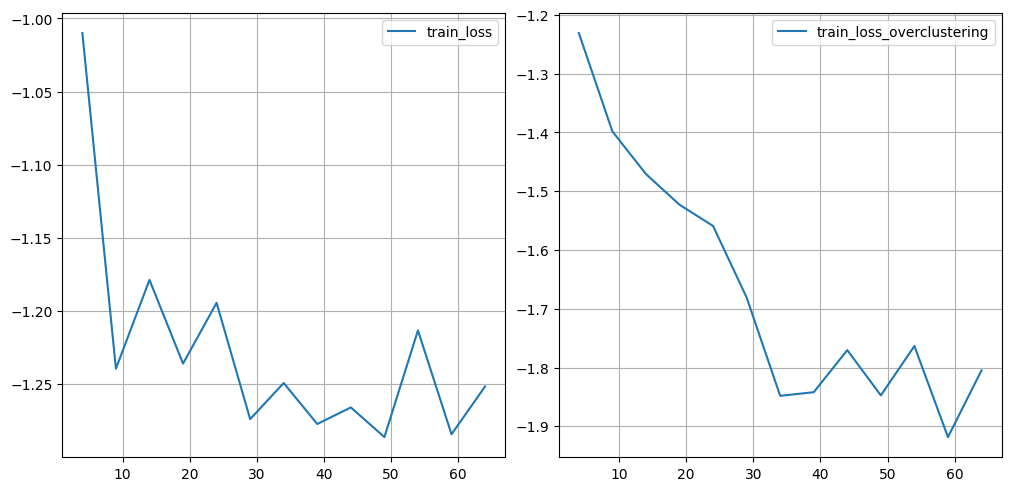

Epoch 66/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 67/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 68/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 69/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 70/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

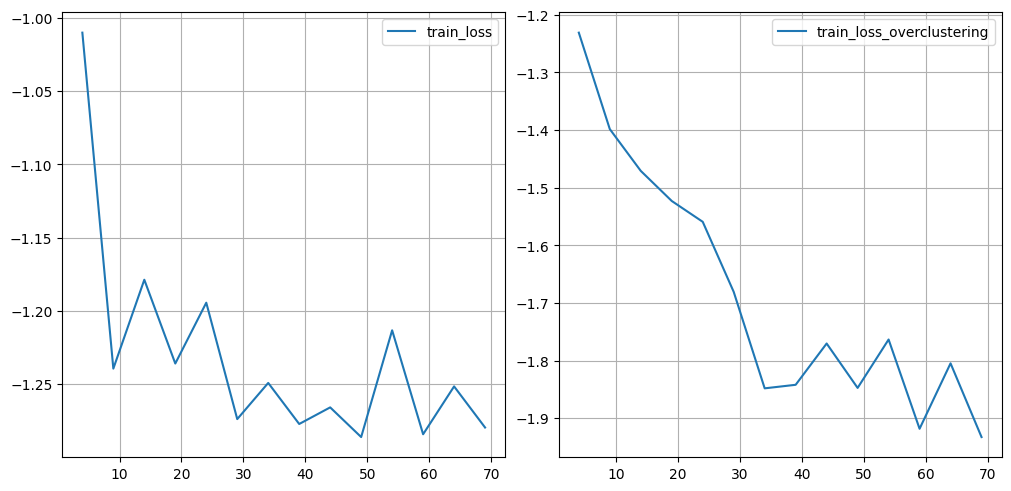

Epoch 71/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 72/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 73/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 74/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 75/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

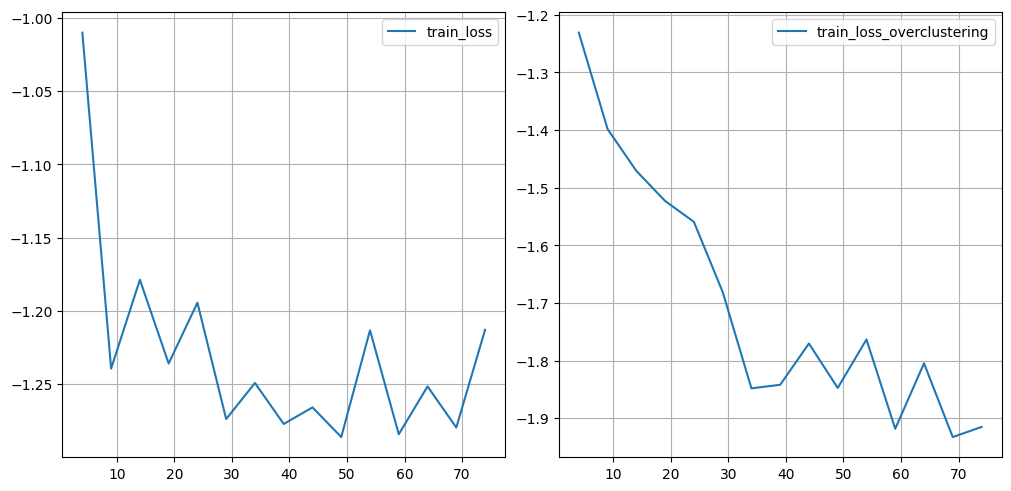

Epoch 76/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 77/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 78/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 79/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 80/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

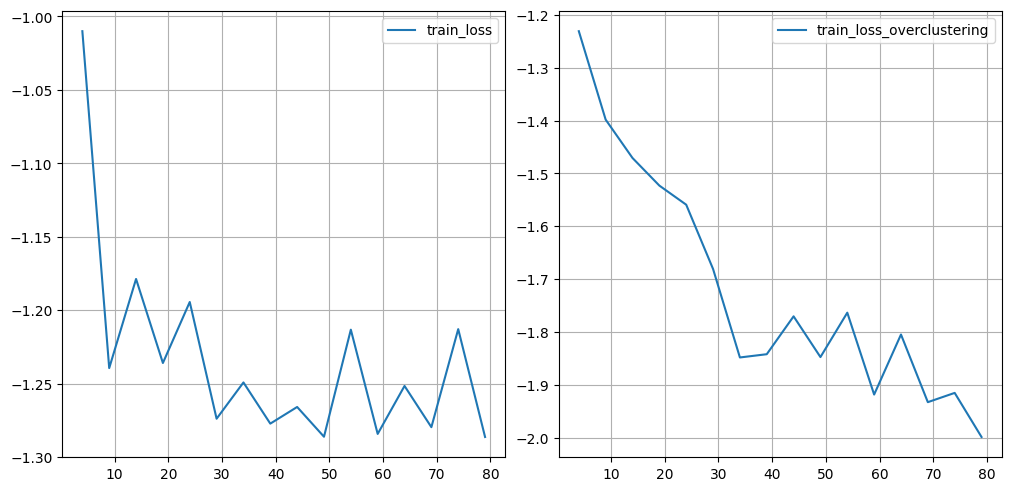

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 81/200:
Epoch 82/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 83/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 84/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 85/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

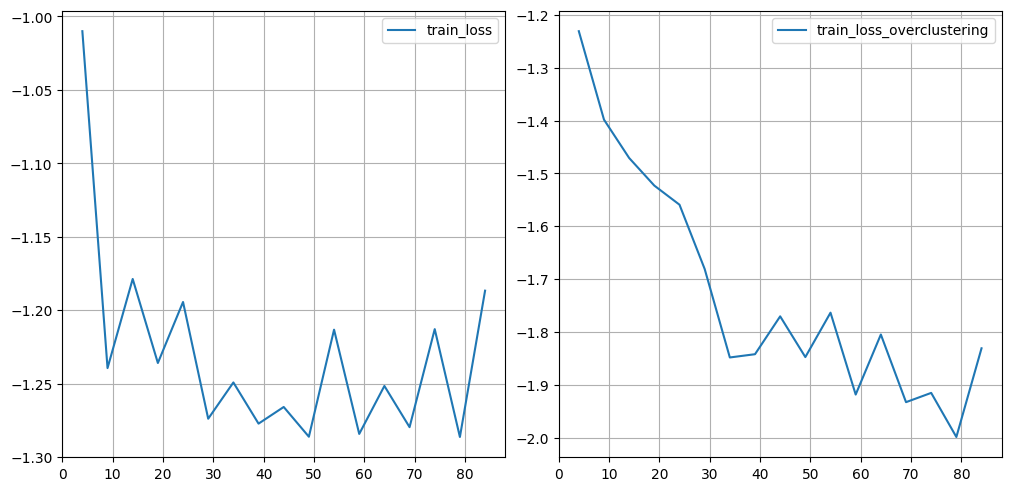

Epoch 86/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 87/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 88/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 89/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 90/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

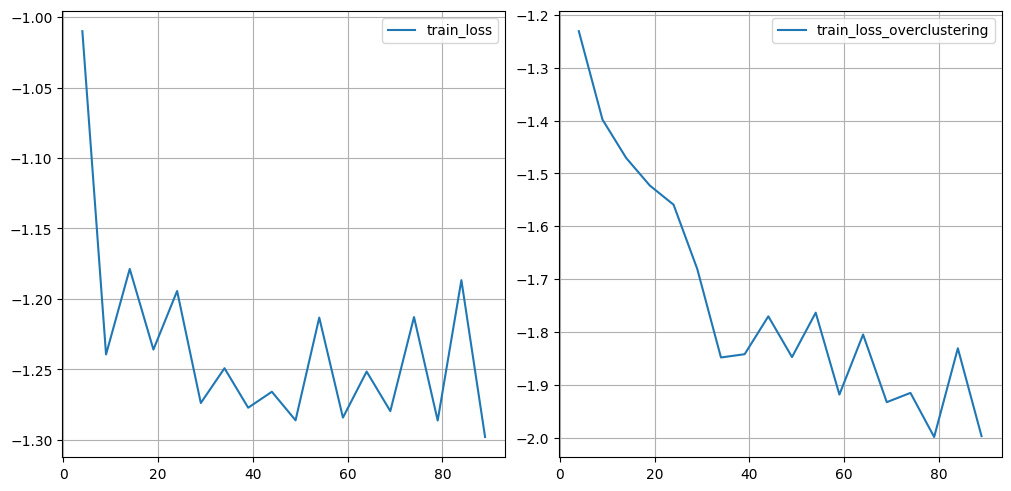

Epoch 91/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 92/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 93/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 94/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 95/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

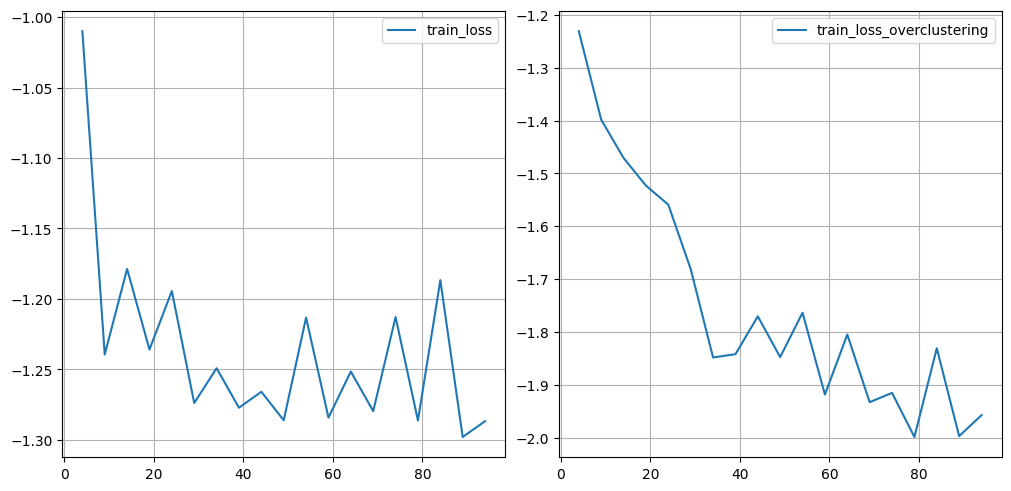

Epoch 96/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 97/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 98/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 99/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 100/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

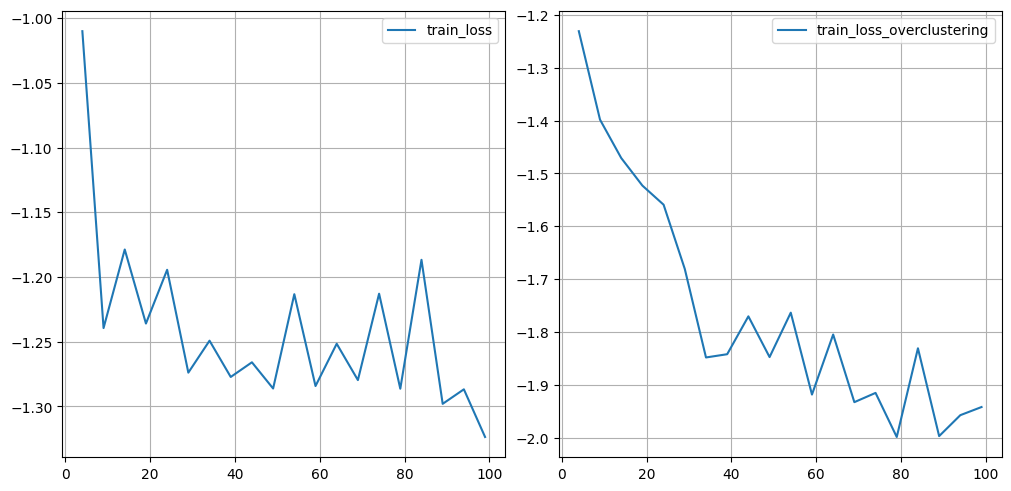

Epoch 101/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 102/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 103/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 104/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 105/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

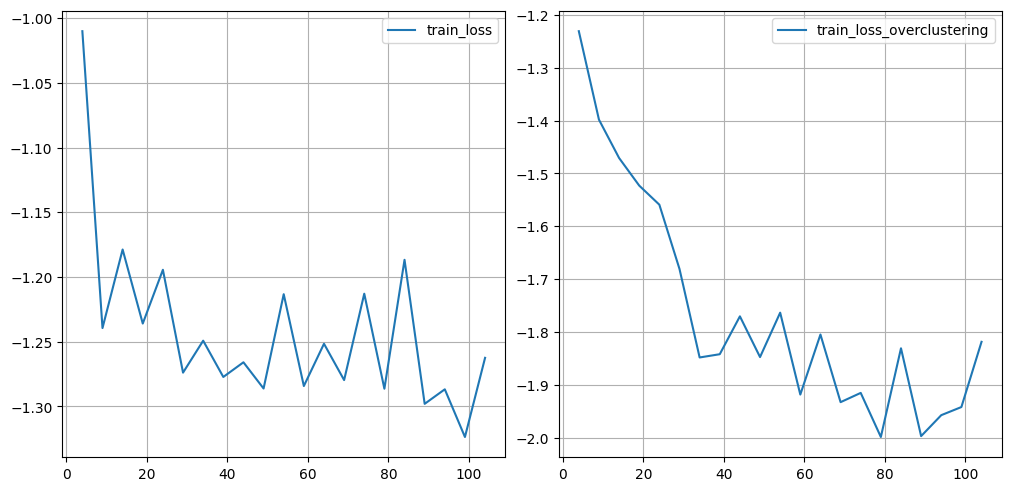

Epoch 106/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 107/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 108/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 109/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 110/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

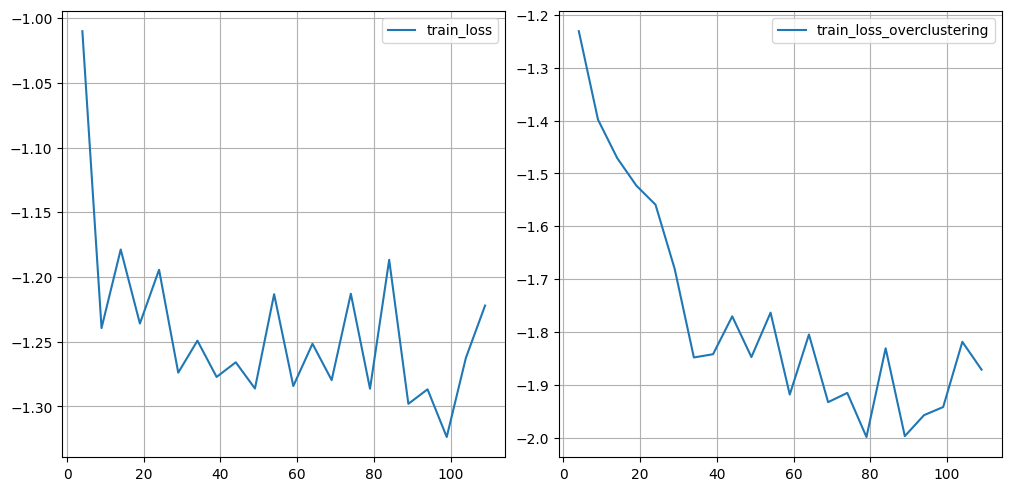

Epoch 111/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 112/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 113/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 114/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 115/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

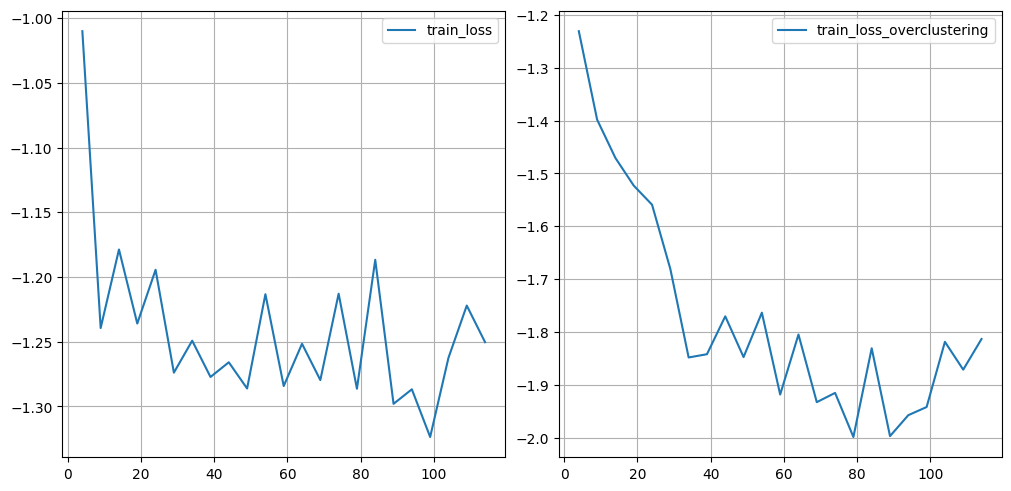

Epoch 116/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 117/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 118/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 119/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 120/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

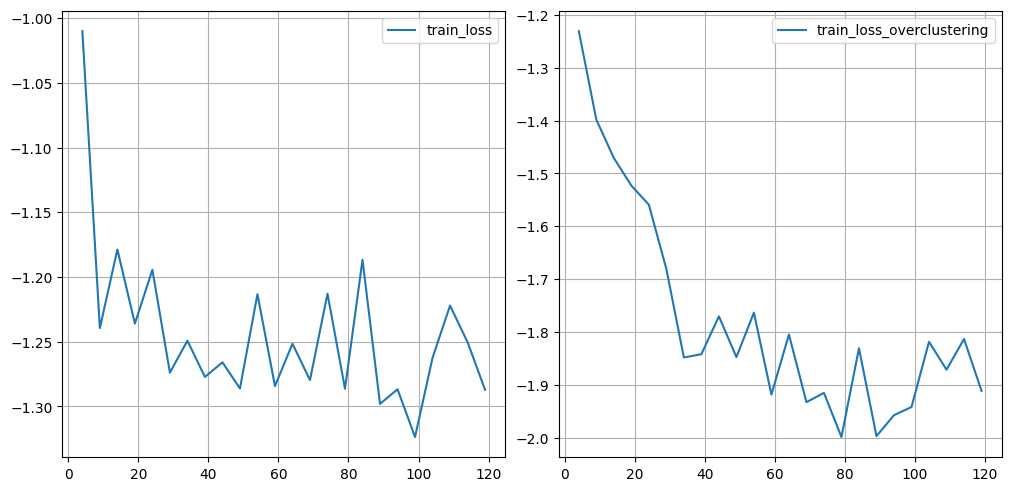

Epoch 121/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 122/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 123/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 124/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 125/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

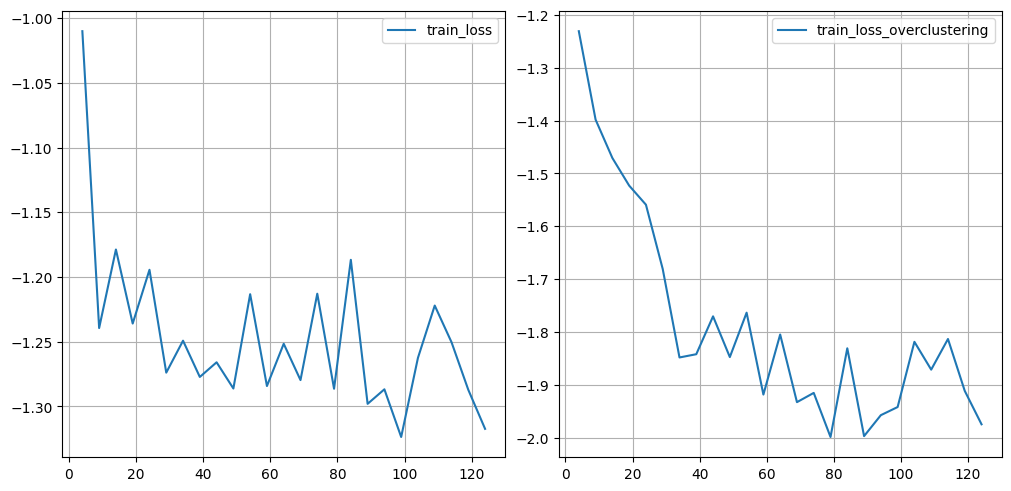

Epoch 126/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 127/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 128/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 129/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 130/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

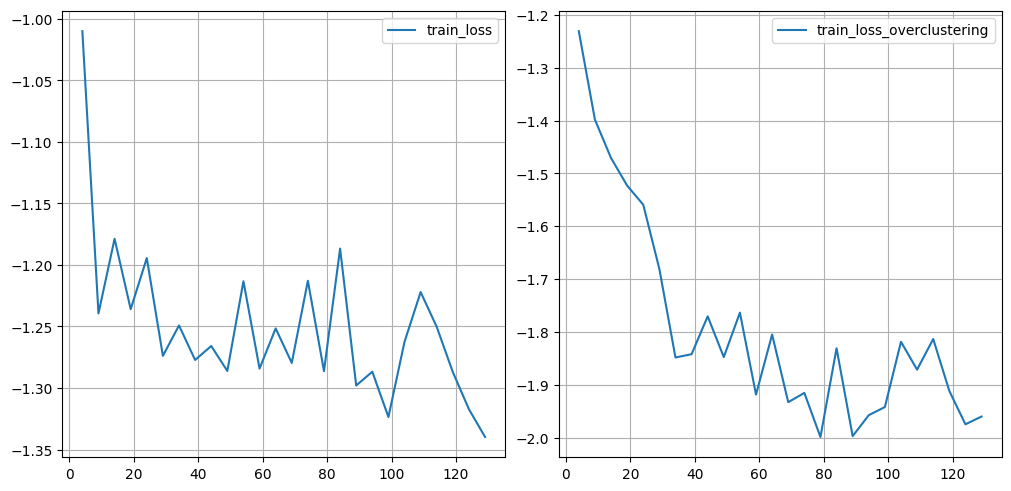

Epoch 131/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 132/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 133/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 134/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 135/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

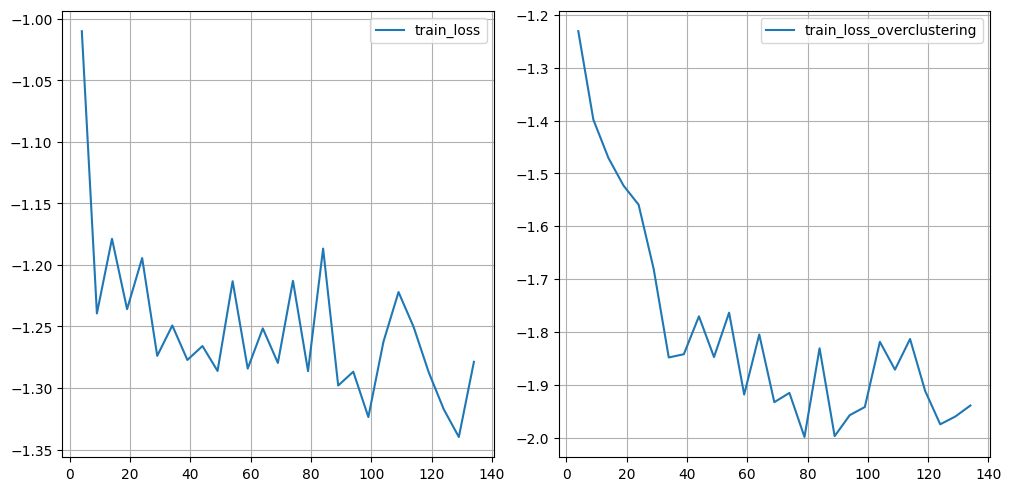

Epoch 136/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 137/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 138/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 139/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 140/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

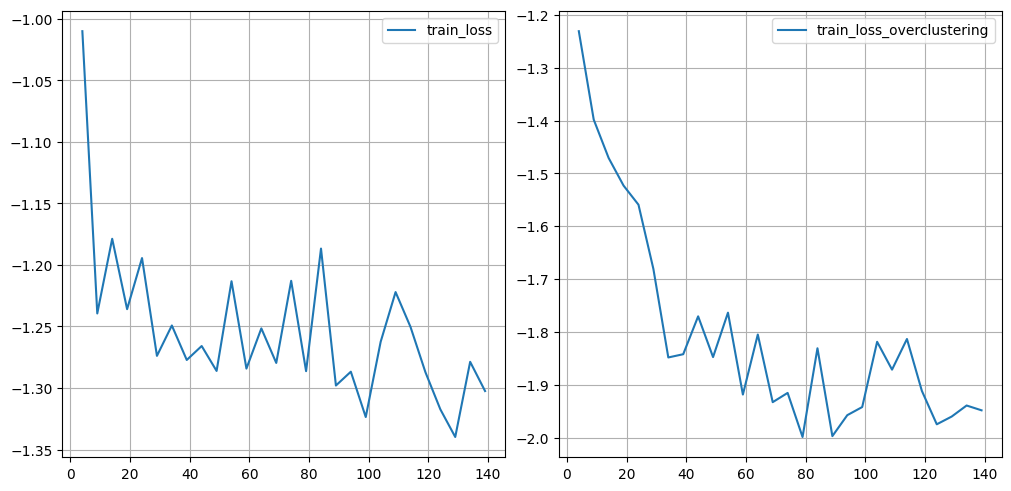

Epoch 141/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 142/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 143/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 144/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 145/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

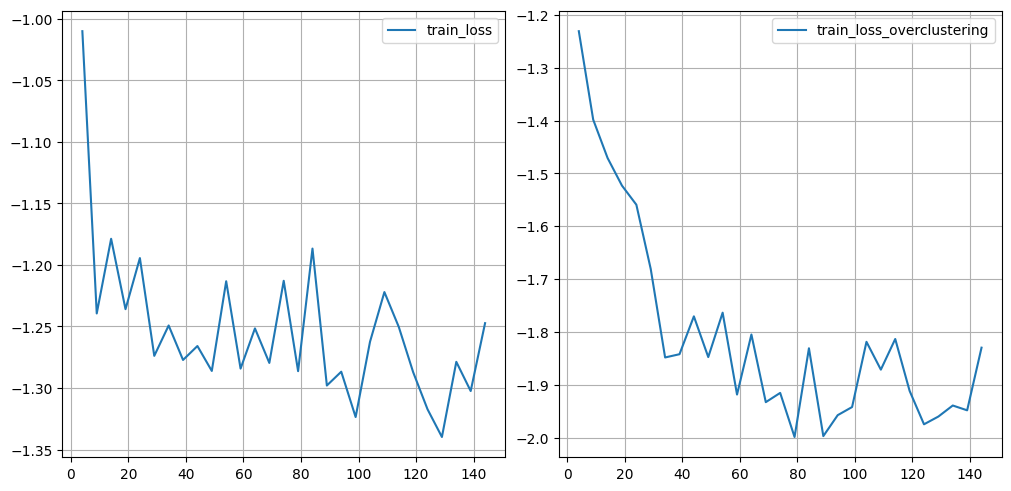

Epoch 146/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 147/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 148/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 149/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 150/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

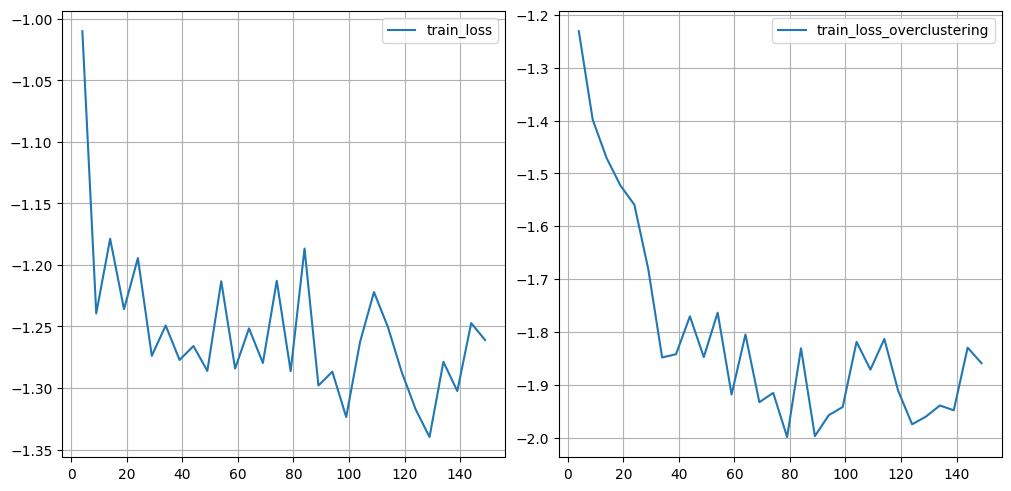

Epoch 151/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 152/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 153/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 154/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 155/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

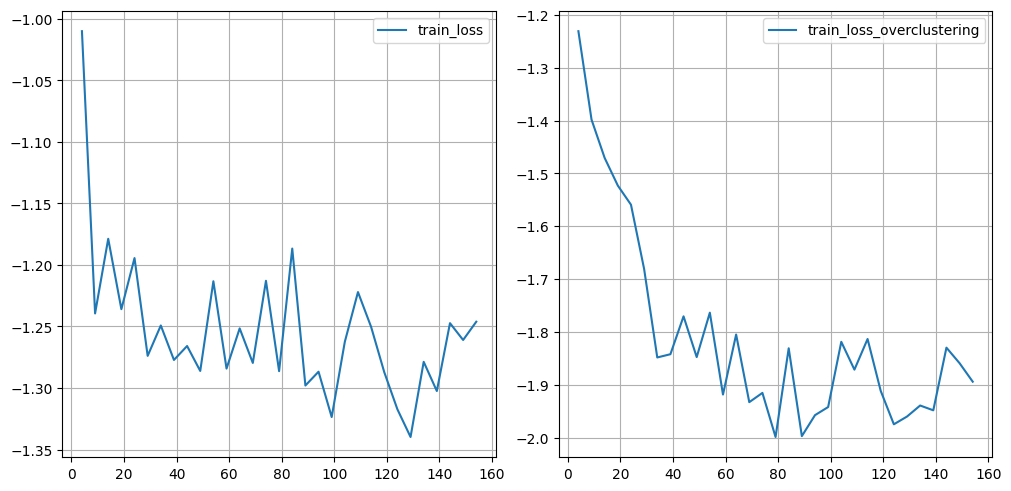

Epoch 156/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 157/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 158/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 159/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 160/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

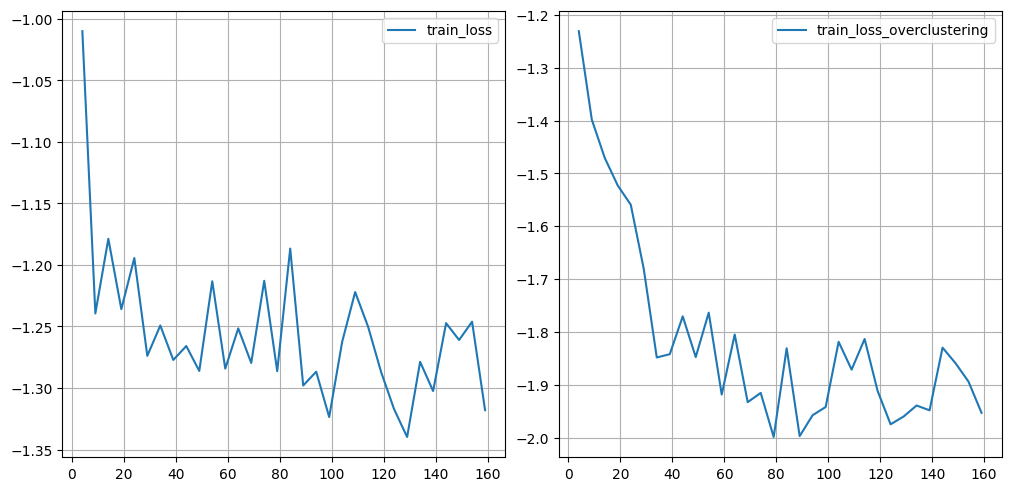

Epoch 161/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 162/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 163/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 164/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 165/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

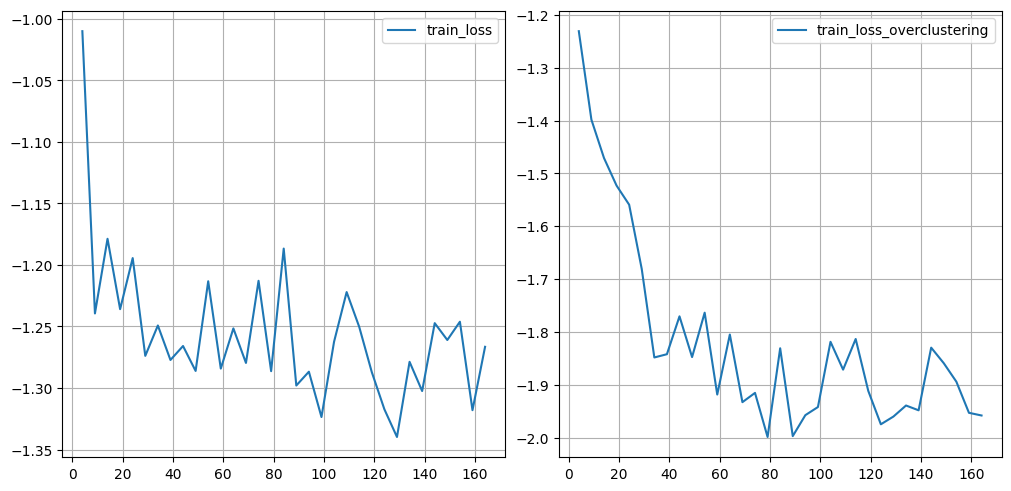

Epoch 166/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 167/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 168/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 169/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 170/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

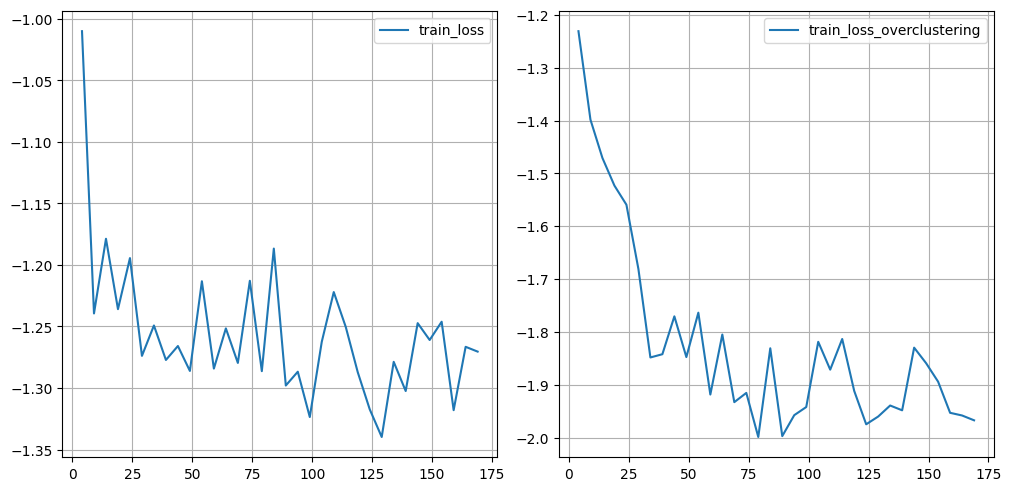

Epoch 171/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 172/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 173/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 174/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 175/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

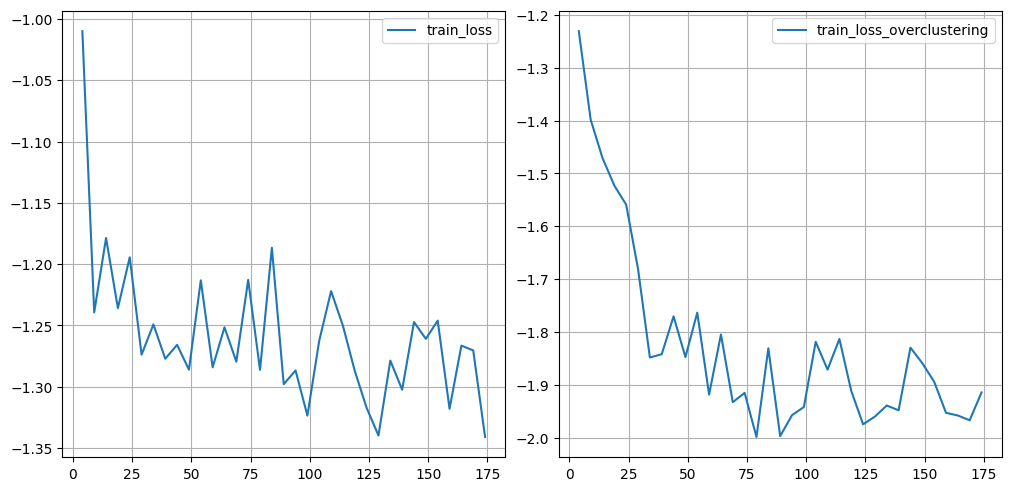

Epoch 176/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 177/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 178/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 179/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 180/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

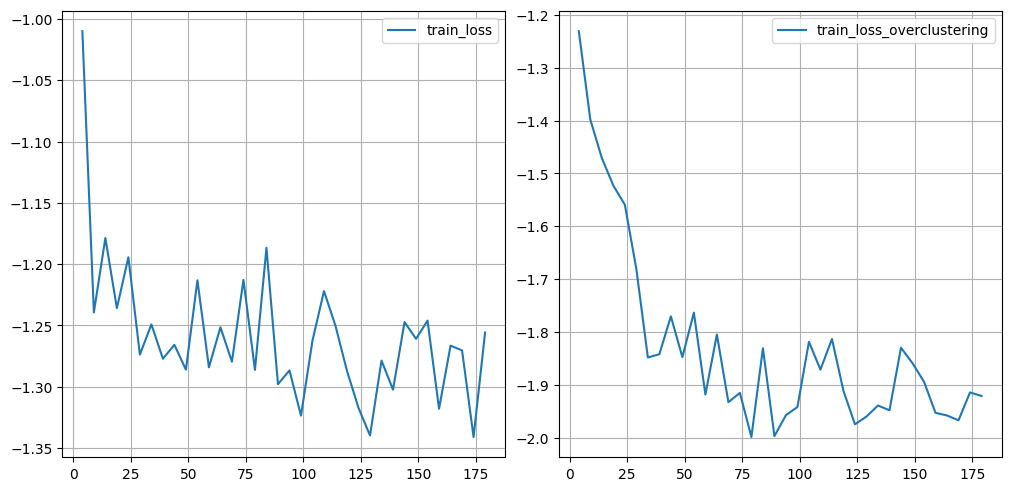

Epoch 181/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 182/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 183/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 184/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 185/200:


  0%|          | 0/47 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

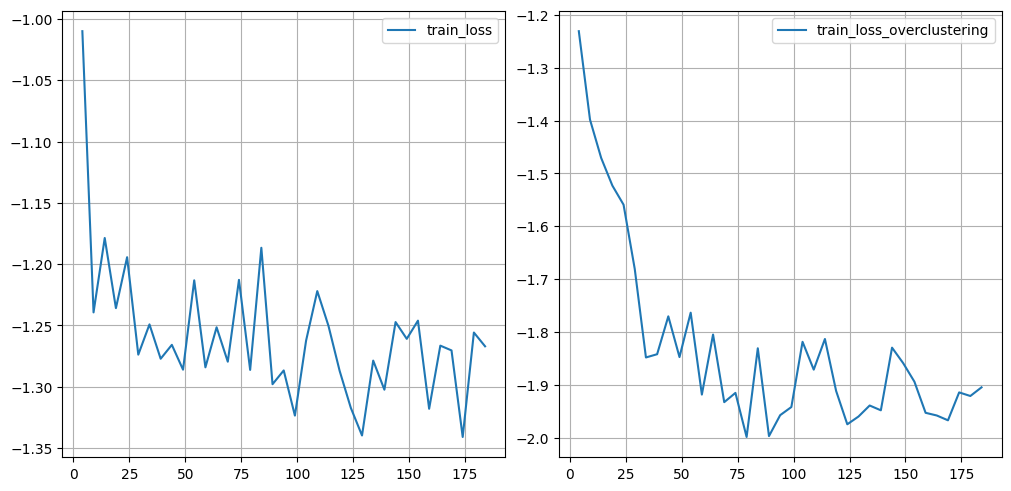

In [ ]:
# training
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

train(model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=200, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5)

In [ ]:
test_model = ResNetClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_cifar10.pth"))
test_model.to(device)

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    model, dataloader_val, device=device
)

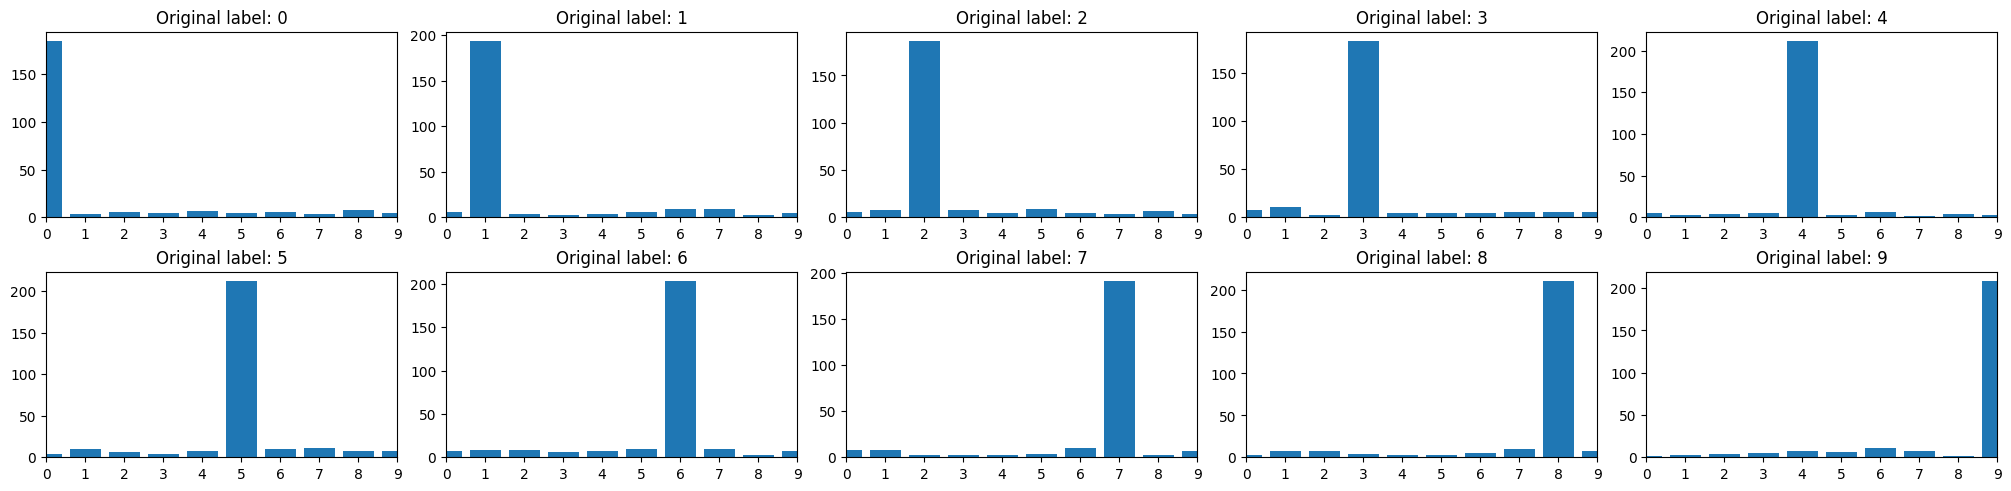

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.598 
Homogeneity score: 0.598 
Completeness score: 0.594
